# Frequentist intervals

In lectures we learned a construction of frequentist intervals (the Neyman construction) that is designed to acheive a good coverage. In this notebook, we're going to apply this method to our simple counting experiment and calculate a frequentist interval, and calculate  the coverage of the intervals.  


$$
L(\lambda) = \lambda^{n}e^{-\lambda}
$$

where we've dropped the $n!$ in the likelihood (for reasons that will be clear in the future). $\lambda$ is the parameter of interest.

This likelihood just says that $n$ is distributed as a Poisson $n\sim \mathrm{Poisson(\lambda)}$.

As usual, we take negative logs and define, 

$$
q = -2\ln L(\lambda)
$$


## Neyman intervals with profiled likelihood

We'll start with the Neyman construction for our interval. In this case, we'll calculate a 68% interval (commonly refered to as a 1$\sigma$ interval) on the parameter $\lambda$.

In [1]:
%matplotlib inline

import numpy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 12})
#plt.rcParams['figure.figsize'] = (15, 12)

The test statistic  is based on the likelihood ratio, 

$$
 \zeta_{\lambda} = q(\lambda) - q(\hat{\lambda})
$$

which depends on the value of $\lambda$. 

In [2]:
def q(l,np):
    return -2*(np*numpy.log(l) - l)

def qmin(np):
    if np==0: return 0
    else: return q(np,np)

Finally, we have all of the pieces to define our test-statistic.

In [3]:
# calculate test statistic
@numpy.vectorize
def zetal(np,lamb):
  q_value            = q(lamb,np)
  q_min,lambda_min   = qmin(np),np
  return q_value-q_min

In [4]:
# return a set of heights for each true value of mu
# for each value, we would mark on where 68% of the distribution lives

def histo_zetal(lamb):
  # find the best (profiled) nuisance parameter values for the data (n,0)
  ntoys = 10000
  toy_n   = numpy.random.poisson(lamb,size=ntoys)
  zetal_dist = zetal(toy_n,lamb)
  zetal_dist.sort() ; zeta_68 = numpy.quantile(zetal_dist,0.68)
  return zetal_dist, zeta_68

Suppose we observed $n=4$ events. We can take a look at how compatible the data are with the hypothesis defined by $\lambda=2$. 

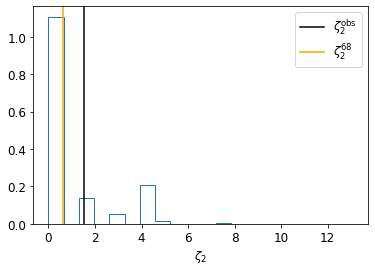

zeta_68= 0.6137056388801092
zeta_obs= 1.5451774444795623


In [13]:
n=4
zeta_obs_2 = zetal(n,2)

distribution_2, zeta_68_2 =  histo_zetal(2)
plt.hist(distribution_2,bins=20,histtype='step',density=True)
plt.axvline(zeta_obs_2,color='black',label="$\zeta_{2}^{\mathrm{obs}}$")
plt.axvline(zeta_68_2,color='orange',label="$\zeta_{2}^{68}$")
plt.xlabel("$\zeta_{2}$")
plt.legend()
plt.savefig("zeta_2ex.pdf")
plt.show()

print("zeta_68=",zeta_68_2)
print("zeta_obs=",zeta_obs_2)

In this case, the observed value `zeta_obs` is larger  than `zeta_68`. This means that the observed value is not contained in the part of the distribution that contains 68% of the outcome! So we would not accept this point ($\lambda=2$) into our 68% interval. 

Now let's repeat for a range of $\lambda$ values and report the full interval (i.e the range of points we accept). Note that this takes a little while to run.

In [6]:
l_range   = numpy.arange(0.1,16,0.1)
zeta_range = numpy.arange(0.1,10,0.2)
zeta_obs_vals = []
zeta_68_vals  = []
l_interval = []
densities = []

for l_test in l_range:
  zeta_obs = zetal(n,l_test)
  zetal_toys,zeta_68 = histo_zetal(l_test)

  # we're also keeping a record of all the distributions
  density_vals = plt.hist(zetal_toys,density=True,bins=zeta_range)
  densities.append(density_vals[0])

  zeta_68_vals.append(zeta_68)
  zeta_obs_vals.append(zeta_obs)
  if zeta_obs <= zeta_68 : l_interval.append(l_test)

plt.clf()
# Print out the results
l_l, l_u = min(l_interval),max(l_interval)
l_hat = n
print("interval -> (%.2f,%.2f)"%(l_l,l_u),", l = %.2f + %.2f -%.2f "%(l_hat,l_u-l_hat,l_hat-l_l))

interval -> (2.40,6.70) , l = 4.00 + 2.70 -1.60 


<Figure size 432x288 with 0 Axes>

We can plot the distribution of $\zeta_{\lambda}$ for each of our $\lambda$ values that we tested. The colour map below shows the density of our test-statistic disribution. We also can overlay the values of $\zeta_{68}$ that we determined. 

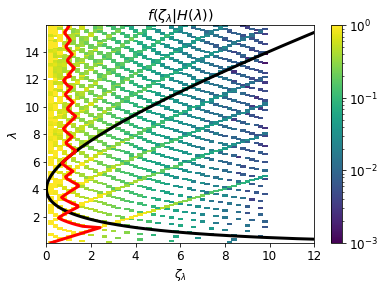

In [7]:
X,Y = numpy.meshgrid(zeta_range,l_range)
c = plt.pcolor(X,Y,densities, \
    norm=LogNorm(vmin=0.001, vmax=1.0))
plt.colorbar(c)
plt.plot(zeta_obs_vals,l_range,color='black',linewidth=3)
plt.plot(zeta_68_vals,l_range,color='red',linewidth=3)
plt.xlabel("$\zeta_{\lambda}$")
plt.ylabel("$\lambda$")
plt.title("$f(\zeta_{\lambda}|H(\lambda))$")
plt.xlim(0,12)
plt.savefig("frequentist_interval.pdf")
plt.show()

You can see some odd structures here at small values of $\mu$, that seem to smooth out at larger values. Also the value of  $\zeta_{68}$ seems to settle down at larger values. This will be important for our next topic on coverage and Wilks'  theorem. 

## Coverage

We can check what the coverage of our methods (say for the 68\% interval) by determining the *fraction of intervals* in $\lambda$, as a function of the true value $\lambda_0$, that contain $\lambda_{0}$. 

It sounds like a rather painful ordeal given that calculating a single interval can take time, however, we do not need to calculate each interval to figure out the coverage. 

Remember that $\lambda$ is included in the interval provided $\zeta^{\mathrm{obs}}_{\lambda}\leq\zeta^{68}_{\lambda}$. For the Neyman construction, we can use toys to calculate $\zeta^{68}_{\lambda}$.

From Wilks' theorem, we know that the 68% confidence interval can be obtained by picking the values of $\lambda$ for which $\zeta^{\mathrm{obs}}_{\lambda}\leq1$. We can also calculate the coverage for this method. 

Finally, we can also see what the coverage looks like for a simplistic method by which we just choose the interval as  $n_{\mathrm{obs}}-\sqrt{n_{\mathrm{obs}}} < \lambda < n_{\mathrm{obs}}+\sqrt{n_{\mathrm{obs}}}$

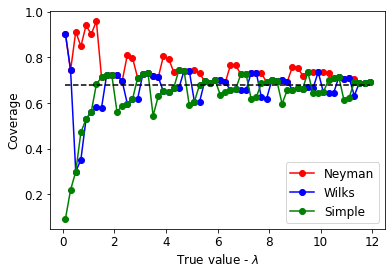

In [8]:
def get_t68_neyman(l):
  ntoys = 10000
  toy_n   = numpy.random.poisson(l,size=ntoys)
  zetal_dist = numpy.array([zetal(np,l) for np in toy_n])
  zetal_dist.sort() ; zeta_68 = numpy.quantile(zetal_dist,0.68)
  return zeta_68
    
l_range   = numpy.arange(0.1,12,0.2)
n_coverage_toys = 10000

cov_Neyman, cov_WILKS, cov_Simple = [], [], []
for l_test in l_range:
       # Generate from the profiled value of the nuisance parameter
       # we could also test the coverage under other values!
       toy_n   = numpy.random.poisson(l_test,size=n_coverage_toys)

       t68_Neyman = get_t68_neyman(l_test)
       t68_WILKS  = 1
       zeta_obs_vals = numpy.array([ zetal(np,l_test) for np in toy_n ])
    
       coverage_Neyman = float(len([x for x in zeta_obs_vals if x <= t68_Neyman ]))/n_coverage_toys
       coverage_WILKS  = float(len([x for x in zeta_obs_vals if x <= t68_WILKS  ]))/n_coverage_toys
       coverage_Simple = float(len(list(filter(lambda x: l_test<x+x**0.5 and l_test>x-x**0.5,toy_n ))))/n_coverage_toys
       
       cov_Neyman.append(coverage_Neyman)
       cov_WILKS.append(coverage_WILKS)
       cov_Simple.append(coverage_Simple)

plt.plot(l_range,cov_Neyman,color='red',marker="o",label="Neyman")
plt.plot(l_range,cov_WILKS,color='blue',marker="o",label="Wilks")
plt.plot(l_range,cov_Simple,color='green',marker="o",label="Simple")

plt.plot(l_range,[0.68 for m in l_range],color='black',linestyle="--")
plt.xlabel("True value - $\lambda$")
plt.ylabel("Coverage")
plt.legend()
plt.savefig("coverage_example.pdf")
plt.show()

You can see that the Neyman construction gives very close coverage to the desired 68\% except at small $\lambda$, where the discrete nature of the Poisson distribution makes it difficult to find the exact $\zeta^{68}_{\lambda}$ - in fact this is still seen at larger values, though the effect gets reduced. Instead, the Wilks method, jumps between over-coverage and undercoverage, eventually settling down only above $\lambda\sim 8$.

Below we plot the distribution of $\zeta_{\lambda}$ at $\lambda=0.1$ and $\lambda=9$. For the larger value, away from the boundary the approximation of a $\chi^{2}(1)$ is  more accurate.

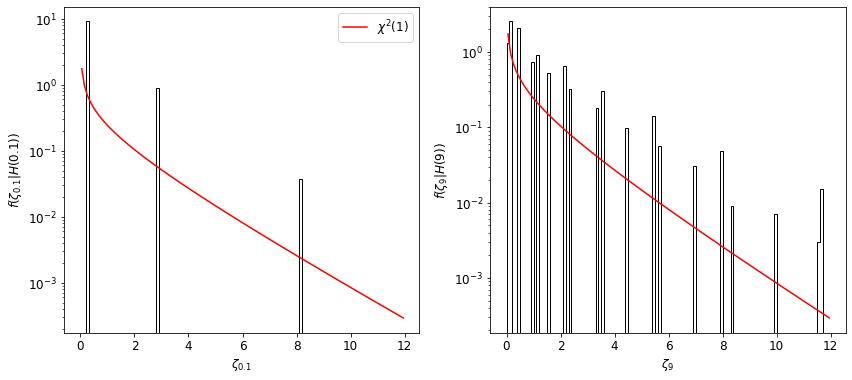

In [12]:
from scipy.stats import chi2

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

chi2vals = chi2.pdf(numpy.arange(0.05,12.05,0.1),df=1)

ax1.hist(histo_zetal(0.1)[0], \
    bins=numpy.arange(0,12,0.1),range=(0,12),\
    color='black',histtype='step',density=True)
ax1.plot(numpy.arange(0.05,12.05,0.1),chi2vals,color='red',label='$\chi^{2}(1)$')
ax2.hist(histo_zetal(9)[0], \
    bins=numpy.arange(0,12,0.1),range=(0,12),\
    color='black',histtype='step',density=True)
ax2.plot(numpy.arange(0.05,12.05,0.1),chi2vals,color='red',label='$\chi^{2}(1)$')

ax1.set_xlabel("$\zeta_{0.1}$")
ax1.set_ylabel("$f(\zeta_{0.1}|H(0.1))$")
ax2.set_xlabel("$\zeta_{9}$")
ax2.set_ylabel("$f(\zeta_{9}|H(9))$")
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.legend()
plt.savefig("zlambda_dists_example.pdf")
plt.show()